# Modeling of Supercritical CO2 Joule Cycle

## Introduction

In recent years, the search for efficient and sustainable energy solutions has led to significant advances in power generation technologies. Among these innovations, the Supercritical CO2 Joule Cycle stands out as a promising candidate for improving the efficiency and economics of thermal power plants, particularly in the context of renewable energy integration.

This report analyzes an advanced model of the Supercritical CO2 Joule Cycle, adopting the operational boundaries of the Andasol 2 solar thermal power plant. The Supercritical CO2 Joule Cycle was modeled using TESPy software, configured with two compressors, heat recuperators, a water cooler, a heater, and a turbine. These components were interconnected to optimize the flow of energy through the cycle.

In addition, this analysis goes beyond mere simulation and explores potential adaptations of the supercritical CO2 Joule cycle specifically tailored for tower CSP plants. Tower CSP plants represent a significant advancement in solar thermal technology, offering increased operational flexibility and potential for higher efficiencies. By addressing the unique operational limitations of CSP applications, this study aims to propose optimisations that can further enhance the performance of the cycle in solar driven power generation scenarios.


# Sunshot Targets

CSP (Concentrated Solar Power) technologies use mirrors to reflect and concentrate sunlight onto receivers that collect solar energy and convert it into heat. This heat is then used to produce electricity through a turbine or another type of heat engine that drives a generator. CSP systems are generally classified based on how they collect solar energy, including linear Fresnel systems, central receiver (power tower) systems, parabolic dish systems, and parabolic trough systems. Most CSP systems installed to date consist of parabolic troughs, although power tower systems are increasingly being deployed commercially. The dispatchability of CSP results in energy production during periods of highest demand, offsetting the most costly (and often highest emissions) fossil generators. Additionally, CSP can ramp up quickly, providing various ancillary services such as regulation and spinning reserves.

To reach the U.S. Department of Energy's (DOE) SunShot Initiative cost target of 6 ¢/kWh, cost and performance improvements in all subsystems within a CSP plant are necessary. A key driver for improving performance is through efficiency gains achieved by integrating CSP solar fields with advanced power cycles, with the supercritical CO2 (sCO2) Brayton power cycle being a leading candidate for CSP applications. To achieve the desired efficiency of 50%, necessary to meet the SunShot target, these sCO2 systems are expected to operate at temperatures as high as 750°C.

Power tower CSP plants can achieve higher operating temperatures compared to line-focus systems such as parabolic trough and linear Fresnel plants. Currently, the two main power tower technology concepts pursued by developers are defined by the type of heat-transfer fluid (HTF) in the receiver: steam or molten salt. In direct-steam power towers, heliostats reflect sunlight onto a steam receiver located at the top of a tower, similar to a boiler in a conventional coal-fired Rankine-cycle power plant. The steam is then fed into a turbine/generator to generate electricity. In molten-salt power towers, the salt is heated from 290°C to about 565°C by concentrated sunlight and used to generate high-pressure steam.

Supercritical CO2 (sCO2) Brayton-cycle energy conversion systems transform heat energy into electrical energy using sCO2 rather than steam in the Rankine cycle systems commonly used in today's CSP, coal, nuclear, and combined-cycle gas plants. Studies indicate that the closed-loop sCO2 cycle offers higher cycle efficiency versus superheated or supercritical steam cycles at temperatures relevant for CSP applications. Brayton-cycle systems using sCO2 are more compact, have lower thermal mass, and simpler power blocks compared to Rankine cycles. Cycle configurations such as partial-cooling cycle and recompression with main compression intercooling, along with reheat, appear capable of reaching the SunShot target of 50% efficiency, even with dry cooling. However, these high temperatures require alternative HTFs to today's molten nitrate salts, which are limited to temperatures below 600°C, with potential technology pathways including particle, advanced molten-salt, and gas-phase HTFs. [Concentrating Solar Power Gen3 Demonstration Roadmap](https://www.nrel.gov/docs/fy17osti/67464.pdf)

## Supercritical CO2 Joule Cycle code construction

The creation and development of the code for the power plant simulation is performed in a very similar manner to that performed for Andasol 2. In the following sections, only the major differences and the various assumptions adopted will be analysed. The cycle consists of several key components:
- **Compressors (CP1 and CP2)**: These components compress the CO2 to higher pressures, crucial for maintaining cycle efficiency.
- **Heat Exchangers (Recuperators)**: Recuperators facilitate heat exchange between exhaust streams, optimizing thermal efficiency.
- **Turbine**: The turbine expands CO2 to generate mechanical power, which is then converted into electrical energy.
- **Heat Exchangers (Heater and Cooler)**: These components facilitate heat transfer to and from external sources, crucial for maintaining working fluid temperatures within operational limits.

![Representation of the cycle under examination](picture/CO2.svg)

### Network Cycle topology creation

As done in Andasol, the relevent Libraries are imported. Then, the Network is created with a CO2 fluid.

In [1]:
from tespy.networks import Network
from tespy.components import (
    Sink, Source, Turbine, SimpleHeatExchanger, Merge, Splitter,
    HeatExchanger, CycleCloser, Compressor)
from tespy.connections import Connection, Bus

In [2]:
# setting up network
jouleCycle = Network(fluids=['CO2'])
jouleCycle.set_attr(
    T_unit='C', p_unit='bar', h_unit='kJ / kg', m_unit='kg / s',
    s_unit="kJ / kgK")


The needed components are defined for the thermal cycle according to the TESPy library. Each component is now explained:

- **Source and Sink**: `water_in` represents the water source in the cycle and `water_out` represents the water sink in the cycle.

- **CycleCloser**: `closer` is the component that closes the cycle, ensuring mass balance between inlet and outlet.

- **Compressor**: `cp1` and `cp2` are the two compressors in the cycle (Compressor 1 and Compressor 2), both belonging to the functional group 'CMP'.

- **HeatExchanger**: `rec1` and `rec2`are the two heat exchangers in the cycle (Recuperator 1 and Recuperator 2), both belonging to the functional group 'REC'.

- **SimpleHeatExchanger**: `cooler` as a simple heat exchanger for cooling water and `heater` as a simple heat exchanger for heating the fluid in the cycle.

- **Turbine**: `turb` is the turbine in the cycle, which converts fluid energy into mechanical energy.

- **Splitter and Merge**: `sp1` is the splitter in the cycle, part of the functional group 'REC' and `m1` is the merge in the cycle, part of the functional group 'REC'.


In [3]:
# components definition
water_in = Source('Water source')
water_out = Sink('Water sink')

closer = CycleCloser('Cycle closer')

cp1 = Compressor('Compressor 1', fkt_group='CMP')
cp2 = Compressor('Compressor 2', fkt_group='CMP')

rec1 = HeatExchanger('Recuperator 1', fkt_group='REC')
rec2 = HeatExchanger('Recuperator 2', fkt_group='REC')

cooler = SimpleHeatExchanger('Water cooler')
heater = SimpleHeatExchanger('Heater')

turb = Turbine('Turbine')

sp1 = Splitter('Splitter 1', fkt_group='REC')
m1 = Merge('Merge 1', fkt_group='REC')

Each connection is defined by specifying the components and their respective ports that are being connected. The connections are then added to the cycle network.

- `c1` connects the outlet of the water cooler (`cooler`) to the inlet of Compressor 1 (`cp1`).
- `c2` connects the outlet of Compressor 1 (`cp1`) to the inlet of Recuperator 1 (`rec1`).
- `c3` connects the outlet of Recuperator 2 (`rec2`) to the inlet of the heater (`heater`).
- `c0` connects the outlet of the heater (`heater`) to the inlet of the cycle closer (`closer`).
- `c4` connects the outlet of the cycle closer (`closer`) to the inlet of the turbine (`turb`).
- `c5` connects the outlet of the turbine (`turb`) to the inlet of Recuperator 2 (`rec2`).
- `c6` connects the outlet of Splitter 1 (`sp1`) to the inlet of the water cooler (`cooler`).
- `c10` connects the outlet of Splitter 1 (`sp1`) to the inlet of Compressor 2 (`cp2`).
- `c11` connects the outlet of Compressor 2 (`cp2`) to the inlet of Merge 1 (`m1`).
- `c12` connects the outlet of Recuperator 1 (`rec1`) to the inlet of Merge 1 (`m1`).
- `c13` connects the outlet of Merge 1 (`m1`) to the inlet of Recuperator 2 (`rec2`).
- `c14` connects the outlet of Recuperator 2 (`rec2`) to the inlet of Recuperator 1 (`rec1`).
- `c15` connects the outlet of Recuperator 1 (`rec1`) to the inlet of Splitter 1 (`sp1`).

In [4]:
# connections definition
# power cycle
c1 = Connection(cooler, 'out1', cp1, 'in1', label='1')
c2 = Connection(cp1, 'out1', rec1, 'in2', label='2')
c3 = Connection(rec2, 'out2', heater, 'in1', label='3')

c0 = Connection(heater, 'out1', closer, 'in1', label='0')
c4 = Connection(closer, 'out1', turb, 'in1', label='4')
c5 = Connection(turb, 'out1', rec2, 'in1', label='5')
c6 = Connection(sp1, 'out1', cooler, 'in1', label='6')

c10 = Connection(sp1, 'out2', cp2, 'in1', label='10')
c11 = Connection(cp2, 'out1', m1, 'in2', label='11')
c12 = Connection(rec1, 'out2', m1, 'in1', label='12')
c13 = Connection(m1, 'out1', rec2, 'in2', label='13')

c14 = Connection(rec2, 'out1', rec1, 'in1', label='14')
c15 = Connection(rec1, 'out1', sp1, 'in1', label='15')

# add connections to network
jouleCycle.add_conns(c0, c1, c2, c3, c4, c5, c6, c10, c11, c12, c13, c14, c15)

Setting the power bus and heat input bus, specifying mechanical and electrical generator efficiencies.

In [5]:
# power bus
power = Bus('total output power')
power.add_comps({'comp': turb, 'char': 0.99 * 0.99, 'base': 'component'},
                {'comp': cp1, 'char': 0.98 * 0.97, 'base': 'bus'},
                {'comp': cp2, 'char': 0.98 * 0.97, 'base': 'bus'})

heat_input_bus = Bus('heat input')
heat_input_bus.add_comps({'comp': heater, 'base': 'bus'})

jouleCycle.add_busses(heat_input_bus, power)

### Input values setting

Setting the attributes for the connections and the components. These parameters include temperatures, pressures, mass flow rates, and efficiencies. It was created in such a way as to ensure stable operation over different TIT ranges by parametrically adopting the pressure losses and temperature differences at the heat exchangers. All data are referred to [Exergoeconomic analyses of different sCO2 cycle configurations](https://sco2symposium.com/papers2018/cycles/052_Paper.pdf).

- `c1` is set with a temperature (`T`) of 35°C, a pressure (`p`) of 75 bar, and a fluid composition of 100% CO2.
- `c4` is set with a temperature (`T`) of 384°C, a pressure (`p`) of 258 bar, and a mass flow rate (`m`) of 54 kg/s.
- `c5` is set with a pressure (`p`) of 78 bar.
- `rec1` (Recuperator 1) is set with a pressure ratio (`pr1` and `pr2`) of 0.977 and 0.998 respectively, a lower terminal temperature difference (`ttd_l`) of 10°C, and an upper terminal temperature difference (`ttd_u`) of 25°C.
- `rec2` (Recuperator 2) is set with a pressure ratio (`pr1` and `pr2`) oof 0.987 and 0.997 respectively and a lower terminal temperature difference (`ttd_l`) of 10°C.
- `heater` is set with a pressure ratio (`pr`) of 0.973.

And for the component parameters:

- `turb` (Turbine) is set with an isentropic efficiency (`eta_s`) of 0.90.
- `cp1` (Compressor 1) is set with an isentropic efficiency (`eta_s`) of 0.85.
- `cp2` (Compressor 2) is set with an isentropic efficiency (`eta_s`) of 0.85.


In [6]:
# connection parameters
c1.set_attr(T=35, p=75, fluid={'CO2': 1})
c4.set_attr(T=384, p=258, m=54)
c5.set_attr(p=78)
rec1.set_attr(pr1=0.977, pr2=0.998, ttd_l=10, ttd_u=25)
rec2.set_attr(pr1=0.987, pr2=0.997, ttd_l=10)
heater.set_attr(pr=0.973)

# component parameters
turb.set_attr(eta_s=0.9)
cp1.set_attr(eta_s=0.85)
cp2.set_attr(eta_s=0.85)

### Results output
Solving command launched with simulation results printing without informations regarding iteration results:

In [7]:
# solve final state
jouleCycle.set_attr(iterinfo=False)
jouleCycle.solve(mode='design')

# print results to prompt and generate model documentation
jouleCycle.print_results()


##### RESULTS (Turbine) #####
+---------+-----------+----------+----------+
|         |         P |    eta_s |       pr |
|---------+-----------+----------+----------|
| Turbine | -6.29e+06 | 9.00e-01 | 3.02e-01 |
+---------+-----------+----------+----------+
##### RESULTS (Compressor) #####
+--------------+----------+----------+----------+--------+
|              |        P |    eta_s |       pr |   igva |
|--------------+----------+----------+----------+--------|
| Compressor 1 | 2.47e+06 | 8.50e-01 | 3.55e+00 |    nan |
| Compressor 2 | 1.02e+06 | 8.50e-01 | 3.54e+00 |    nan |
+--------------+----------+----------+----------+--------+
##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| Cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (SimpleHeatExchanger) ##

In [8]:
W_net = abs(power.P.val)
Q_in = heater.Q.val
print(f"Efficiency for a TIT equal to 384°C as in Andasol 2: {round(W_net/Q_in * 100, 2)} %")

Efficiency for a TIT equal to 384°C as in Andasol 2: 23.79 %


During simulation, the cycle was solved to evaluate initial performance. Results indicate lower efficiency than expected based on Andasol 2 data, highlighting the need for adaptations to enhance performance in environments akin to tower CSP plants.

## Adaptation to the boundaries of a tower power tower CSP plants
Drawing from the model and specifications of tower CSP plants, adaptation of the cycle is proposed to optimize efficiency and reliability under specific operating conditions. This includes modifications to operational parameters to maximize overall cycle efficiency. 

Now the Turbine Inlet Temperature (TIT) is changed from 384°C to 600°C

In [9]:
c4.set_attr(T=600, p=258, m=54)

jouleCycle.solve(mode='design')

# print results to prompt and generate model documentation
jouleCycle.print_results()


##### RESULTS (Turbine) #####
+---------+-----------+----------+----------+
|         |         P |    eta_s |       pr |
|---------+-----------+----------+----------|
| Turbine | -8.87e+06 | 9.00e-01 | 3.02e-01 |
+---------+-----------+----------+----------+
##### RESULTS (Compressor) #####
+--------------+----------+----------+----------+--------+
|              |        P |    eta_s |       pr |   igva |
|--------------+----------+----------+----------+--------|
| Compressor 1 | 2.47e+06 | 8.50e-01 | 3.55e+00 |    nan |
| Compressor 2 | 1.02e+06 | 8.50e-01 | 3.54e+00 |    nan |
+--------------+----------+----------+----------+--------+
##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| Cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (SimpleHeatExchanger) ##

In [10]:
W_net = abs(power.P.val)
Q_in = heater.Q.val
print(f"Efficiency in case of a TIT equal to 600°C: {round(W_net/Q_in * 100, 2)} %")

Efficiency in case of a TIT equal to 600°C: 38.38 %


## Boundaries variation of TIT

Show how by increasing TIT higher efficiencies can be reached.

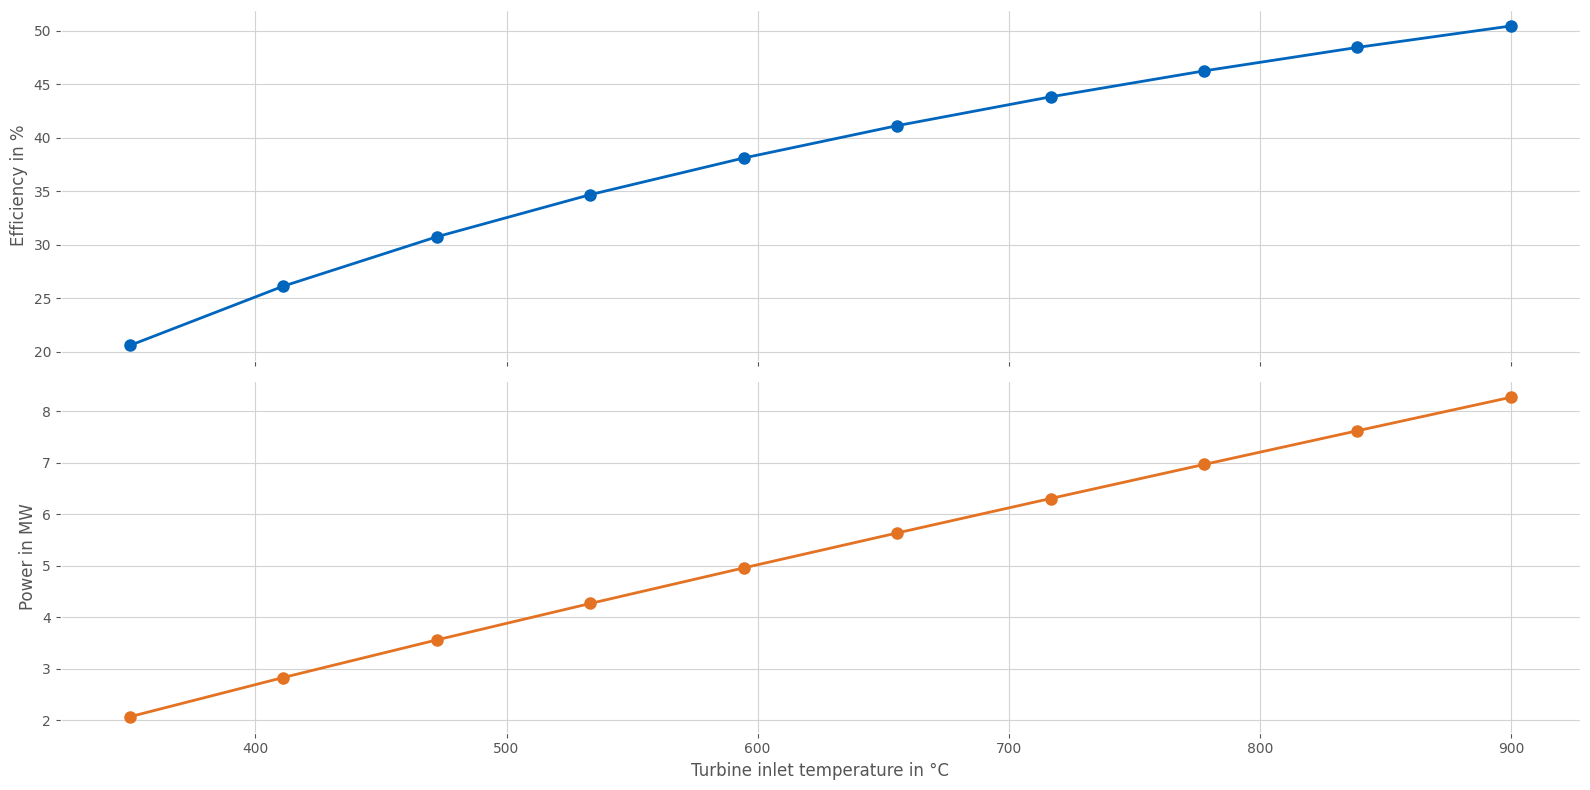

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle

# make text reasonably sized
plt.rc('font', **{'size': 18})

data = {
    'T_livesteam': np.linspace(350, 900, 10)
}
eta = {
    'T_livesteam': []
}
power_c = {
    'T_livesteam': []
}

for T in data['T_livesteam']:
    c4.set_attr(T=T)
    jouleCycle.solve('design')
    eta['T_livesteam'] += [abs(power.P.val) / heater.Q.val * 100]
    power_c['T_livesteam'] += [abs(power.P.val) / 1e6]

# reset to base temperature
c4.set_attr(T=700)

with mplstyle.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex='col', sharey='row')
    
    ax = ax.flatten()
    [a.grid() for a in ax]
    
    i = 0
    for key in data:
        # Plotting lines
        ax[i].plot(data[key], eta[key], marker='o', linestyle='-', color="#0065bd", markersize=8,
            linewidth=2)
        ax[i].set_facecolor('white')
        ax[i].grid(True, color="#D3D3D3")
        ax[i + 1].plot(data[key], power_c[key], marker='o', linestyle='-', color="#e37222", markersize=8,
            linewidth=2)
        ax[i + 1].set_facecolor('white')
        ax[i + 1].grid(True, color="#D3D3D3")
        i += 1
    
    ax[0].set_ylabel('Efficiency in %')
    ax[1].set_ylabel('Power in MW')
    ax[1].set_xlabel('Turbine inlet temperature in °C')
    plt.tight_layout()
    plt.savefig(r"picture\TIT_variation.svg", format="svg", dpi=300)
    plt.show()

## Result discussion and Performance Analysis

Analysing the efficiencies simulated in the previous sections, it can be seen that the proposed cycle is not suitable for the boundaries conditions of Andasol 2, as an efficiency of about 23.79\% was obtained, which is somewhat lower than its Rankine cycle. As the temperature at the turbine inlet is increased, the use of the following cycle is much more interesting, resulting in an efficiency of about 38.38\% for a TIT equal to 600°C.

If we want to compare our efficiency with the simulation carried out by the reference paper, we have to carry out the simulation with a TIT equal to 600°C. The result is an efficiency of 38.38\% compared to 40.61\% of the reference. The result obtained is somewhat expected, because the cycle we modelled is not optimised to work at a specific temperature, but was developed in such a way that it would have stable behaviour for different turbine inlet temperatures. This choice leads to a slightly lower efficiency in our case.

To optimize the Supercritical CO2 Joule Cycle for tower CSP applications, the following adaptations are proposed:

1. **Turbine Inlet Temperature (TIT) Optimization**: Adjusting TIT to match operational conditions typical in tower CSP plants, aiming to maximize thermal efficiency without compromising equipment integrity.

2. **Component Configuration**: Evaluating the arrangement and sizing of components such as compressors and heat exchangers to enhance overall cycle efficiency and reliability under varying solar conditions.

3. **Integration of Thermal Storage**: Considering the integration of thermal storage systems to mitigate fluctuations in solar irradiance and optimize energy dispatchability.

The modeling and analysis of the Supercritical CO2 Joule Cycle offer valuable insights into its potential application in tower CSP plants. By aligning operational parameters with the specific requirements of CSP technology, significant advancements in efficiency and sustainability can be achieved.

## Future Directions
Future research should focus on:

- **Advanced Control Strategies**: Implementing advanced control algorithms to optimize energy conversion and system reliability.
- **Experimental Validation**: Conducting experimental validations to corroborate simulation results and refine model accuracy.
- **Techno-Economic Analysis**: Performing techno-economic assessments to evaluate the feasibility and cost-effectiveness of implementing adapted Supercritical CO2 Joule Cycles in commercial CSP projects.

This report serves as a foundational step towards integrating advanced power cycle technologies into the evolving landscape of renewable energy, contributing to global efforts in combating climate change and advancing sustainable energy solutions.